# 1. Dataset Loading and Environment Setup

In [1]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [2]:
!gdown 1Ale0UvXib0oiOQmtlbAJCARxPxCg3yOk
!gdown 16_nlvHX92GyDyIhchvs39p7KSnywdpd6
!gdown 1I8jfE53cHlMyxQDeTbUmpOnjV7PKs2Bg

Downloading...
From: https://drive.google.com/uc?id=1Ale0UvXib0oiOQmtlbAJCARxPxCg3yOk
To: /content/train.csv
100% 200M/200M [00:05<00:00, 38.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=16_nlvHX92GyDyIhchvs39p7KSnywdpd6
To: /content/dev.csv
100% 24.7M/24.7M [00:01<00:00, 14.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1I8jfE53cHlMyxQDeTbUmpOnjV7PKs2Bg
To: /content/test.csv
100% 24.8M/24.8M [00:00<00:00, 106MB/s]


In [28]:
%%capture
!pip install datasets
!pip install transformers
!pip install --upgrade accelerate
!pip install evaluate
!pip install datsets transformers[sentencepiece]
!pip install sentencepiece
!pip install rouge-score

In [29]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import csv
from collections import defaultdict
from rouge_score import rouge_scorer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_id = 0 if str(device) == 'cuda' else -1

In [5]:
train_df = pd.read_csv('train.csv')
dev_df = pd.read_csv('dev.csv')
test_df = pd.read_csv('test.csv')

In [6]:
# Given the size of our datasets: 460,000 for training, 57,500 for validation, 57,500 for testing
# It would take way too long to train our T5 model. Thus, we decided to sample a subset of these
# original datasets
train_df = train_df.sample(4600, random_state=42)
dev_df = dev_df.sample(575, random_state=42)
test_df = test_df.sample(575, random_state=42)

In [7]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

# 2. Data Analysis
We want to see the distribution of review token lengths and summary token lengths to decide the max length to impose on our model

In [8]:
# Lists to store token lengths
review_lengths = []
summary_lengths = []
reviews = train_df['reviewText']
summaries = train_df['summary']
# Calculate token lengths for reviews
for review in reviews:
    tokenized_review = tokenizer.encode(review)
    review_lengths.append(len(tokenized_review))

# Calculate token lengths for summaries
for summary in summaries:
    tokenized_summary = tokenizer.encode(summary)
    summary_lengths.append(len(tokenized_summary))

Token indices sequence length is longer than the specified maximum sequence length for this model (1171 > 512). Running this sequence through the model will result in indexing errors


In [9]:
pd.Series(review_lengths).describe()

count    4600.000000
mean       86.177609
std       160.825313
min         2.000000
25%        12.000000
50%        36.000000
75%        89.250000
max      2673.000000
dtype: float64

In [10]:
pd.Series(summary_lengths).describe()

count    4600.000000
mean        7.038913
std         4.646027
min         2.000000
25%         4.000000
50%         5.000000
75%         9.000000
max        40.000000
dtype: float64

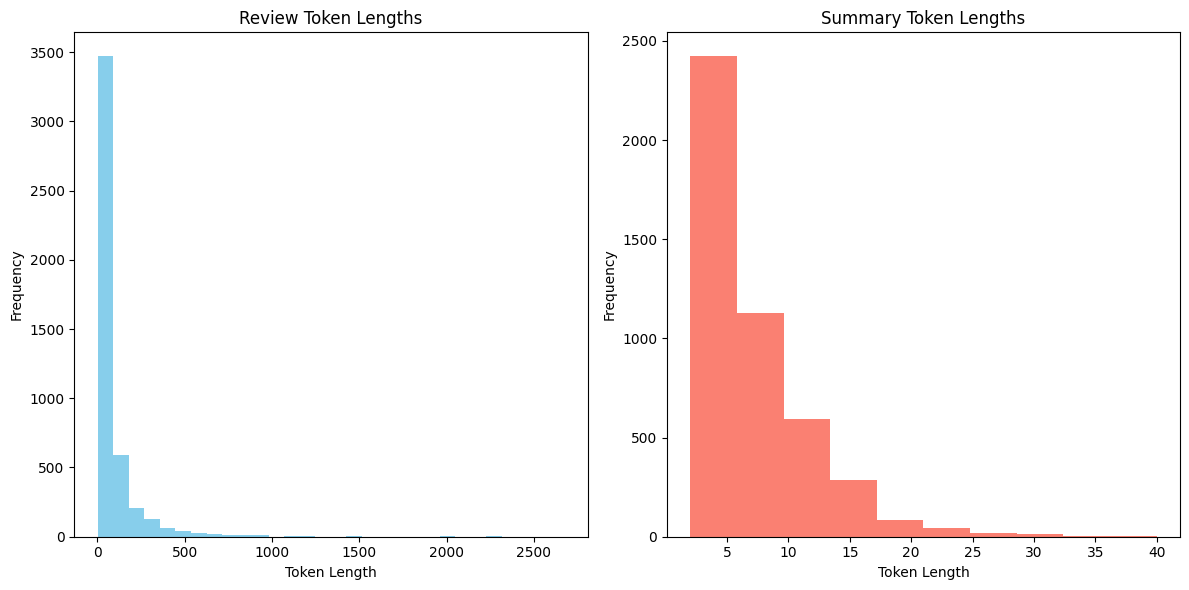

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot distribution of review token lengths
axs[0].hist(review_lengths, bins=30, color='skyblue')
axs[0].set_title('Review Token Lengths')
axs[0].set_xlabel('Token Length')
axs[0].set_ylabel('Frequency')

# Plot distribution of summary token lengths
axs[1].hist(summary_lengths, bins=10, color='salmon')
axs[1].set_title('Summary Token Lengths')
axs[1].set_xlabel('Token Length')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [12]:
train_df['summarize_prompt'] = train_df.apply(lambda x: 'summarize: ' + x['reviewText'], axis=1)
dev_df['summarize_prompt']   = dev_df.apply(lambda x: 'summarize: ' + x['reviewText'], axis=1)
test_df['summarize_prompt']  = test_df.apply(lambda x: 'summarize: ' + x['reviewText'], axis=1)

# 3. Creating a Custom Dataset

Since most reviews are under 128 tokens, we will set that as our maximum review length and truncate the rest of the review

In [13]:
max_review_length = 128
input_ids = tokenizer(train_df['summarize_prompt'].tolist(), return_tensors='pt', max_length=max_review_length, truncation=True, padding=True)

Since most of the summary lengths are under 16 tokens, we will set the maximum review length to be 16

In [14]:
# Tokenize the target data
max_summary_length = 16
target_ids = tokenizer(train_df['summary'].tolist(), return_tensors='pt', max_length=max_summary_length, truncation=True, padding=True)

In [15]:
class SummarizationDataset(Dataset):
    def __init__(self, input_ids, target_ids):
        self.input_ids = input_ids
        self.target_ids = target_ids

    def __len__(self):
        return len(self.input_ids['input_ids'])

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids['input_ids'][idx],
            'attention_mask': self.input_ids['attention_mask'][idx],
            'labels': self.target_ids['input_ids'][idx]
        }

# 4. Model Training

In [16]:
batch_size = 64
dataset = SummarizationDataset(input_ids, target_ids)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [17]:
epochs = 5
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

model.to(device)
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {average_loss}')

Epoch 1/5, Loss: 3.199621801575025
Epoch 2/5, Loss: 1.533301184574763
Epoch 3/5, Loss: 1.3348076774014368
Epoch 4/5, Loss: 1.26446456876066
Epoch 5/5, Loss: 1.2303445976641443


In [18]:
# Save the trained model
model.save_pretrained("t5_summarization_model")
tokenizer.save_pretrained("t5_summarization_model")

('t5_summarization_model/tokenizer_config.json',
 't5_summarization_model/special_tokens_map.json',
 't5_summarization_model/spiece.model',
 't5_summarization_model/added_tokens.json')

# 5. Generate and Evaluate Results

In [31]:
def rouge_score(prediction, ground_truth):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(prediction, ground_truth)
    return scores

In [32]:
def evaluate(predictions, ground_truths):
  rouge1_f = 0
  rouge2_f = 0
  rougeL_f = 0

  num_reviews = len(predictions)
  for pred, actual in zip(predictions, ground_truths):
    scores = rouge_score(pred, actual)
    rouge1_f += scores['rouge1'][2]
    rouge2_f += scores['rouge2'][2]
    rougeL_f += scores['rougeL'][2]

  rouge1_f = rouge1_f / num_reviews
  rouge2_f = rouge2_f / num_reviews
  rougeL_f = rougeL_f / num_reviews

  return (rouge1_f, rouge2_f, rougeL_f)

In [19]:
def generate_summary(text):
    input_ids = tokenizer.encode(text, return_tensors="pt", max_length=max_review_length, truncation=True)
    input_ids = input_ids.to(device)
    summary_ids = model.generate(input_ids, max_length=max_summary_length, num_beams=4, length_penalty=1.0, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [20]:
# Example text for summarization
example_text = train_df.iloc[0]['reviewText']
# Generate summary
summary = generate_summary(example_text)

# Print the results
print("Original Text:")
print(example_text)
print("\nGenerated Summary:")
print(summary)
print("\nActual Summary:")
print(train_df.iloc[0]['summary'])

Original Text:
Works great for its simplicity. You can use it to control water flow.

Generated Summary:
Works great for its simplicity

Actual Summary:
simple


In [21]:
dev_predictions = dev_df['summarize_prompt'].apply(generate_summary)
dev_references = dev_df['summary']

In [22]:
test_predictions = test_df['summarize_prompt'].apply(generate_summary)
test_references = test_df['summary']

In [23]:
train_predictions = train_df['summarize_prompt'].apply(generate_summary)
train_references = train_df['summary']

In [33]:
print("Training Eval")
rouge1_f, rouge2_f, rougeL_f = evaluate(train_predictions, train_references)
print("ROUGE-1 F-Score: ", (rouge1_f))
print("ROUGE-2 F-Score: ", (rouge2_f))
print("ROUGE-L F-Score: ", (rougeL_f))
print("-------------")
print("Dev Eval")
rouge1_f, rouge2_f, rougeL_f = evaluate(dev_predictions, dev_references)
print("ROUGE-1 F-Score: ", (rouge1_f))
print("ROUGE-2 F-Score: ", (rouge2_f))
print("ROUGE-L F-Score: ", (rougeL_f))
print("-------------")
print("Test Eval")
rouge1_f, rouge2_f, rougeL_f = evaluate(test_predictions, test_references)
print("ROUGE-1 F-Score: ", (rouge1_f))
print("ROUGE-2 F-Score: ", (rouge2_f))
print("ROUGE-L F-Score: ", (rougeL_f))

Training Eval
ROUGE-1 F-Score:  0.2688615481221139
ROUGE-2 F-Score:  0.20275500404517457
ROUGE-L F-Score:  0.2664068671714938
-------------
Dev Eval
ROUGE-1 F-Score:  0.27647478404103526
ROUGE-2 F-Score:  0.20967446142520715
ROUGE-L F-Score:  0.2742593731129589
-------------
Test Eval
ROUGE-1 F-Score:  0.2692746751904478
ROUGE-2 F-Score:  0.20318547355199723
ROUGE-L F-Score:  0.26498922405893505


## Write our results to a file

In [24]:
def write_to_file(data, file_name):
    with open(file_name, 'w') as txtfile:
        for row in data:
            txtfile.write(str(row) + '\n')

In [25]:
write_to_file(dev_predictions, 'strong_dev_pred.txt')
write_to_file(dev_references, 'strong_dev_ref.txt')

In [26]:
write_to_file(test_predictions, 'strong_test_pred.txt')
write_to_file(test_references, 'strong_test_ref.txt')

In [27]:
write_to_file(train_predictions, 'strong_train_pred.txt')
write_to_file(train_references, 'strong_train_ref.txt')